# **Importing Libraries**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import copy

In [ ]:
 import torch.optim as optim

# **Data Fetching**

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=0e53e81fb0804685891202acc4897d7b982a54bb6276e9cc5f66e2a7c80320cd
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip

--2021-04-14 22:22:10--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip’

nature_12K.zip      100%[===================>]   3.55G  45.2MB/s    in 65s     

2021-04-14 22:23:15 (56.0 MB/s) - ‘nature_12K.zip’ saved [3816687935/3816687935]



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
!mkdir train_local
!unzip nature_12K.zip -d train_local

Streaming output truncated to the last 5000 lines.
  inflating: train_local/inaturalist_12K/train/Arachnida/1ac25349af662e85f577a31f64beca41.jpg  
  inflating: train_local/inaturalist_12K/train/Arachnida/117ef7f1812725f359500448a258e713.jpg  
  inflating: train_local/inaturalist_12K/train/Arachnida/6409254954c3b46d88d64f0bf4c632fa.jpg  
  inflating: train_local/inaturalist_12K/train/Arachnida/aaed865750bd52944658a7dd23366948.jpg  
  inflating: train_local/inaturalist_12K/train/Arachnida/460cc09ef510d400a4d47a836ddd45e6.jpg  
  inflating: train_local/inaturalist_12K/train/Arachnida/55c48c3afef0b745e53951284cdb2db4.jpg  
  inflating: train_local/inaturalist_12K/train/Arachnida/bff3daa961ee96a37ebe12dc0bcce504.jpg  
  inflating: train_local/inaturalist_12K/train/Arachnida/9082d4f2107bccf1f14d71c8944be607.jpg  
  inflating: train_local/inaturalist_12K/train/Arachnida/93d0130423d42f7c6228150eb95a2a93.jpg  
  inflating: train_local/inaturalist_12K/train/Arachnida/051aba6d7bc324bad76bd438ed3c

# **Data Preprocessing**

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(32), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [ ]:
transform_horizontal = transforms.Compose([
    transforms.RandomResizedCrop(32),                                        
    transforms.RandomHorizontalFlip(),                                       
    transforms.ToTensor(),
    ])

In [ ]:
transform_vertical = transforms.Compose([
     transforms.RandomResizedCrop(32),                                     
    transforms.RandomVerticalFlip(),                                       
    transforms.ToTensor(),
    ])

In [ ]:
transform_Invert= transforms.Compose([
    transforms.RandomResizedCrop(32),                                  
    transforms.RandomInvert(),                                       
    transforms.ToTensor(),
    ])

In [ ]:
image_datasets = torchvision.datasets.ImageFolder(root= "/content/train_local/inaturalist_12K/train",  transform=transform_train)

# **Data Augmentation** 
(Don't esecute this...this will take very long time)

In [ ]:
image_datasets_horizontallyFlipped= torchvision.datasets.ImageFolder(root= "/content/train_local/inaturalist_12K/train",  transform=transform_horizontal)

In [ ]:
image_datasets_VerticallyFlipped= torchvision.datasets.ImageFolder(root= "/content/train_local/inaturalist_12K/train",  transform=transform_vertical)

In [ ]:
image_datasets_Inverted= torchvision.datasets.ImageFolder(root= "/content/train_local/inaturalist_12K/train",  transform=transform_Invert)

In [ ]:
image_datasets = image_datasets + image_datasets_Inverted + image_datasets_VerticallyFlipped + image_datasets_horizontallyFlipped

In [ ]:
print(type(image_datasets))
print(len(image_datasets))

<class 'torch.utils.data.dataset.ConcatDataset'>
39996


# **Data Loading**

In [ ]:
classes = ('Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia')

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [ ]:
def train_val_dataset(dataset, val_split=0.1):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [ ]:
image_datasets = train_val_dataset(image_datasets)


In [ ]:
X_train=image_datasets['train']
X_Valid=image_datasets['val']

In [ ]:
trainloader = torch.utils.data.DataLoader(X_train, batch_size=128, shuffle=True)
validationloader = torch.utils.data.DataLoader(X_Valid, batch_size=128, shuffle=False)

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([128, 3, 32, 32])
torch.Size([3, 32, 32])
2


In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
def Evaluation(dataloader,model,batch_norm):
  total,correct=0,0
  for data in dataloader:
    inputs,labels=data
    inputs,labels=inputs.to(device),labels.to(device)
    outputs=model(inputs,batch_norm)
    _,pred=torch.max(outputs.data,1)
    total+=labels.size(0)
    correct+=(pred==labels).sum().item()
  return 100*correct/total





# **Our CNN Class**

In [ ]:
class I_Nature_v1(nn.Module):
    def __init__(self,batch_norm,k,file_org,F,d,act_fun):

        #self.input_dim=input
        #self.output_dim=output
        #self.k=k
        #self.F=F
        #self.file_org=file_org
        #self.act_fun=act_fun
        super(I_Nature_v1, self).__init__()
        
        self.cnn_model1 = nn.Sequential(
           nn.Conv2d(3,k,F), #(N,3,800,800)-->(N,16,798,798)
           act_fun,
      
           
           nn.MaxPool2d(2,stride=1),  #(2,2) filter(1st param)  (N,16,798,798)-->(N,16,798,798)
           nn.Conv2d(k,int(k*file_org),F), #(N,16,798,798)-->(N,16,796,796),
          
           act_fun,
           nn.MaxPool2d(2,stride=1), #(N,16,796,796)->(N,16,398,398),
         
           nn.Conv2d(int(k*file_org),int(k*(file_org**2)),F), #(N,16,398,398)-->(N,16,396,396),
        
           act_fun,
           nn.MaxPool2d(2,stride=1), #(N,16,396,396)->(N,16,198,198),
          
#Add 2 Layers
           
           nn.Conv2d(int(k*(file_org**2)),int(k*(file_org**3)),F),    #(N,16,198,198)-->(N,16,196,196),
           #input_dim=output_dim,
           #output_dim=input_dim-self.F+1,
           #self.k=self.k*Self.file_org,
           act_fun,
           nn.MaxPool2d(2,stride=2), #(N,16,196,196)->(N,16,98,98)
           #output_dim=output_dim/2,
           nn.Conv2d(int(k*(file_org**3)),int(k*(file_org**4)),int(F)), #(N,16,98,98)-->(N,6,96,96),
           #input_dim=output_dim,
           #output_dim=input_dim-self.F+1,
           act_fun,
           nn.MaxPool2d(2,stride=2), #(N,6,96,96)->(N,6,24,24)
           #output_dim=output_dim/4
        )




        self.cnn_model2 = nn.Sequential(
           nn.Conv2d(3,k,F), #(N,3,800,800)-->(N,16,798,798)
           nn.BatchNorm2d(int(k)),
           #nn.BatchNorm2d(k),
           act_fun,
      
           
           nn.MaxPool2d(2,stride=1),  #(2,2) filter(1st param)  (N,16,798,798)-->(N,16,798,798)
           nn.Conv2d(k,int(k*file_org),F), #(N,16,798,798)-->(N,16,796,796),
           nn.BatchNorm2d(int(k*(file_org**1))),
           
           act_fun,
           nn.MaxPool2d(2,stride=1), #(N,16,796,796)->(N,16,398,398),
         
           nn.Conv2d(int(k*file_org),int(k*(file_org**2)),F), #(N,16,398,398)-->(N,16,396,396),
           nn.BatchNorm2d(int(k*(file_org**2))),
           act_fun,
           nn.MaxPool2d(2,stride=1), #(N,16,396,396)->(N,16,198,198),
          
#Add 2 Layers
           
           nn.Conv2d(int(k*(file_org**2)),int(k*(file_org**3)),F),    #(N,16,198,198)-->(N,16,196,196),
           nn.BatchNorm2d(int(k*(file_org**3))),
           #input_dim=output_dim,
           #output_dim=input_dim-self.F+1,
           #self.k=self.k*Self.file_org,
           act_fun,
           nn.MaxPool2d(2,stride=2), #(N,16,196,196)->(N,16,98,98)
           #output_dim=output_dim/2,
           nn.Conv2d(int(k*(file_org**3)),int(k*(file_org**4)),int(F)), #(N,16,98,98)-->(N,6,96,96),
           nn.BatchNorm2d(int(k*(file_org**4))),
           #input_dim=output_dim,
           #output_dim=input_dim-self.F+1,
           act_fun,
           nn.MaxPool2d(2,stride=2), #(N,6,96,96)->(N,6,24,24)
           #output_dim=output_dim/4
        )


        input_dim=32
        output_dim=input_dim-F+1  #conv1_outpu
        input_dim=output_dim-2   #Max_pool_layer_1
        output_dim=input_dim-F+1  #conv2_outpu
        output_dim=output_dim-1 #Max_pool_layer_2
        input_dim=output_dim
        output_dim=input_dim-F+1 #conv3_outpu
        output_dim=output_dim-1  #Max_pool_layer_3
        input_dim=output_dim
        output_dim=input_dim-F+1 #conv4_outpu
        output_dim=int(output_dim/2) #Max_pool_layer_4
        
        input_dim=output_dim
        print(output_dim)#4
        output_dim=input_dim-F+1  #conv5_outpu
        print(output_dim)#2
        output_dim=output_dim/2 #Max_pool_layer_5
        output_dim=int(output_dim)
        print(output_dim)



        self.fc_model = nn.Sequential(
           nn.Linear(int(output_dim*output_dim*k*(file_org**4)),120),
           nn.ReLU(),
           nn.Dropout(d),
           nn.Linear(120,10)
        )





    def forward(self, x,batch_norm):
        if (batch_norm==0):
          x = self.cnn_model1(x)
        else:
          x = self.cnn_model2(x)
          
       
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_model(x)
        #print(x.shape)
        return x
    

      


# **Section of Code to run faster for checking correctness(without wandb)**

In [ ]:
    def fit(batch_norm,k,file_org,F,max_epochs,batch_size,d,act_fun=nn.ReLU()):
      import torch.optim as optim
      net = I_Nature_v1(batch_norm,k,file_org,F,d,act_fun).to(device)

     # net = I_Nature_v1(k,file_org,F,act_fun,d).to(device)

      loss_fn = nn.CrossEntropyLoss()
      opt = optim.Adam(net.parameters())
      #self.Model_tree()
      loss_epoch_arr=[]
      loss_valid_epoch_arr=[]
      min_loss=1000
      #max_epochs=10
      
      n_iter=np.ceil(8999/batch_size)
      
      for epoch in range(max_epochs):
        #opt = optim.Adam(net.parameters())
        #print(type(opt))
        #print("hi hjj")
        for i,data in enumerate(trainloader,0):

          inputs,labels=data
          inputs,labels=inputs.to(device),labels.to(device)
          opt.zero_grad()
          outputs=net(inputs,batch_norm) #forwrd_pass
          loss=loss_fn(outputs,labels)
          loss.backward()
          opt.step() #Update the parameter after the backward paas using opt optimiser
          #if(min_loss>loss.item()):  #change by LG
            #min_loss=loss.item()
            #best_model=copy.deepcopy(net.state_dict())
            #print("Min Loss is %.2f" % min_loss)
      
      
          del inputs,labels,outputs
          torch.cuda.empty_cache()
      
          if(i%100==0):
            print("Iteration : %d/%d , Loss: %0.2f " %(i,n_iter,loss.item()))
      
      
      
        for i,data1 in enumerate(validationloader,0):
          inputs_Val,labels_Val=data1
          inputs_Val,labels_Val=inputs_Val.to(device),labels_Val.to(device)
          outputs_val=net(inputs_Val,batch_norm) #forwrd_pass
          loss_val=loss_fn(outputs_val,labels_Val)
          del inputs_Val,labels_Val,outputs_val
          torch.cuda.empty_cache()

         # loss_arr.append(loss.item())
        loss_valid_epoch_arr.append(loss_val.item()) 
        loss_epoch_arr.append(loss.item()) 
        #print("epoch: %d/%d,Validation_accuracy:%.2f" % (epoch,max_epochs,Evaluation(validationloader,net,batch_norm)))
      
      
      plt.plot(loss_epoch_arr)
      plt.show()
      print("Training_accuracy:%.2f" % (Evaluation(trainloader,net,batch_norm)))
      print("Validation_accuracy:%.2f" % (Evaluation(validationloader,net,batch_norm)))

In [ ]:
fit(batch_norm=1,k=128,file_org=1,F=3,max_epochs=20,batch_size=128,d=0.0,act_fun=nn.ReLU())

In [ ]:
print("Training_accuracy:%.2f" % (Evaluation(trainloader,net,batch_norm)))
print("Validation_accuracy:%.2f" % (Evaluation(validationloader,net,batch_norm)))

# **WandB Section** (It will take long to execute)

We have run sweep multiple times as sometimes network was disconnected or agent was getting crashed

In [ ]:
!pip install wandb

In [ ]:


import wandb
!wandb login

In [ ]:
import copy

In [ ]:
    def fit(batch_norm,k,file_org,F,max_epochs,batch_size,d,act_fun=nn.ReLU()):
      import torch.optim as optim
      net = I_Nature_v1(batch_norm,k,file_org,F,d,act_fun).to(device)

     # net = I_Nature_v1(k,file_org,F,act_fun,d).to(device)

      loss_fn = nn.CrossEntropyLoss()
      opt = optim.Adam(net.parameters())
      #self.Model_tree()
      loss_epoch_arr=[]
      loss_valid_epoch_arr=[]
      min_loss=1000
      #max_epochs=10
      
      n_iter=np.ceil(8999/batch_size)
      
      for epoch in range(max_epochs):
        #opt = optim.Adam(net.parameters())
        #print(type(opt))
        #print("hi hjj")
        for i,data in enumerate(trainloader,0):

          inputs,labels=data
          inputs,labels=inputs.to(device),labels.to(device)
          opt.zero_grad()
          outputs=net(inputs,batch_norm) #forwrd_pass
          loss=loss_fn(outputs,labels)
          loss.backward()
          opt.step() #Update the parameter after the backward paas using opt optimiser
          #if(min_loss>loss.item()):  #change by LG
            #min_loss=loss.item()
            #best_model=copy.deepcopy(net.state_dict())
            #print("Min Loss is %.2f" % min_loss)
      
      
          del inputs,labels,outputs
          torch.cuda.empty_cache()
      
          if(i%100==0):
            print("Iteration : %d/%d , Loss: %0.2f " %(i,n_iter,loss.item()))
      
      
      
        for i,data1 in enumerate(validationloader,0):
          inputs_Val,labels_Val=data1
          inputs_Val,labels_Val=inputs_Val.to(device),labels_Val.to(device)
          outputs_val=net(inputs_Val,batch_norm) #forwrd_pass
          loss_val=loss_fn(outputs_val,labels_Val)
          del inputs_Val,labels_Val,outputs_val
          torch.cuda.empty_cache()

         # loss_arr.append(loss.item())
        loss_valid_epoch_arr.append(loss_val.item()) 
        loss_epoch_arr.append(loss.item())

        wandb.log({
          "Epoch":epoch,
          #"Train Acc":accuracy_train,
          "Train loss":loss_epoch_arr[epoch],
          "validation loss":loss_valid_epoch_arr[epoch],
          #"Test Acc":accura
          "Validation Acc":Evaluation(validationloader,net,batch_norm),
          #"layer_param":layer_param1

        })
      
      
        #print("epoch: %d/%d,Train_acc:%.2f,Test_acc:%.2f" % (epoch,max_epochs,Evaluation(trainloader,net),Evaluation(testloader,net)))
      
      
      plt.plot(loss_epoch_arr)
      plt.show()

In [ ]:
wandb.init(project="temp28",
           config={
             "batch_norm":0,
             "k":16,
             "file_org":1,
             "F":3,
              "max_epochs":2,
              "batch_size":128,
              "act_fun":nn.ReLU(),
              "d":0.3
           }
           )

In [ ]:
hyperparameter_defaults= {
             "batch_norm":0,
             "no_of_layers":16,
             "file_org":1,
             "Filter_size":3,
              "max_epochs":2,
              "batch_size":128,
              "drop_out":0.3
}

In [ ]:
sweep_config={
    "name":"Assignment2Q2",
    "method":"grid",
    "metric":{
        'name':'accuracy',
        'goal' : 'maximize'
    },
    "parameters":{
      "batch_norm":{
          "values":[0]
      },
      "no_of_layers":{
          "values":[16,32]
      },
      "file_org":{
          "values":[0.5,1,2]
      },
      "Filter_size":{
          "values":[3]
      },
      "max_epochs":{
          "values":[20] 
      },
      "batch_size":{
          "values":[128]
      },
      "drop_out":{
          "values":[0.2,0.5]
      }


    }
}

In [ ]:
sweep_id12=wandb.sweep(sweep_config,entity="siddharth",project="Assignment2Q2")

Create sweep with ID: sgqescer
Sweep URL: https://wandb.ai/siddharth/Assignment2Q2/sweeps/sgqescer


In [ ]:
def train():
  wandb.init(config=hyperparameter_defaults)
  config=wandb.config
  fit(config.batch_norm,config.no_of_layers,config.file_org,config.Filter_size,config.max_epochs,config.batch_size,config.drop_out,act_fun=nn.ReLU())
   #change


wandb: Agent Starting Run: q1dxcl58 with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 0
wandb: 	batch_size: 128
wandb: 	drop_out: 0.2
wandb: 	file_org: 0.5
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 16


10
8
4
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.30 


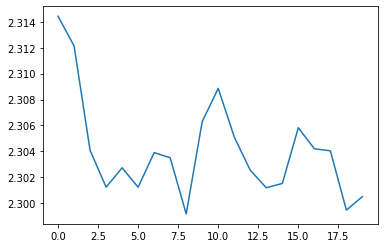

Epoch,19
Train loss,2.30051
validation loss,2.30457
Validation Acc,9.8
_runtime,2643
_timestamp,1618219981
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,█▇▃▂▃▂▃▃▁▄▅▄▃▂▂▄▃▃▁▂
validation loss,▇▄▅▅█▆▄▃▆▅▅▃▄▃▁▄▃▅▇▅
Validation Acc,▇▁▄▁▃▇▆▂█▇▅█▇▇▅▄▇▄▆▆
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: zxwsnxua with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 0
wandb: 	batch_size: 128
wandb: 	drop_out: 0.2
wandb: 	file_org: 0.5
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 32


10
8
4
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.28 
Iteration : 0/71 , Loss: 2.24 
Iteration : 0/71 , Loss: 2.18 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.10 
Iteration : 0/71 , Loss: 2.20 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.08 
Iteration : 0/71 , Loss: 2.08 
Iteration : 0/71 , Loss: 2.06 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.18 
Iteration : 0/71 , Loss: 2.04 
Iteration : 0/71 , Loss: 2.10 
Iteration : 0/71 , Loss: 2.05 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.07 


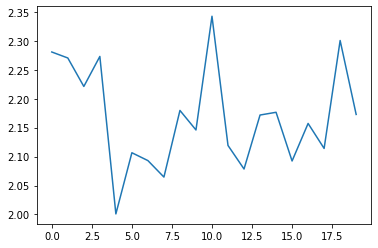

Epoch,19
Train loss,2.17278
validation loss,2.04606
Validation Acc,22.1
_runtime,2652
_timestamp,1618222642
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,▇▇▆▇▁▃▃▂▅▄█▃▃▅▅▃▄▃▇▅
validation loss,█▇▄▅▅▅▄▄▅▃▃▄▃▃▂▄▃▃▃▁
Validation Acc,▁▂▄▅▅▇▆▅▅▆▇▆▇▆▆█▇▆▆▇
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 7rxwsonf with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 0
wandb: 	batch_size: 128
wandb: 	drop_out: 0.2
wandb: 	file_org: 1
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 16


10
8
4
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.20 
Iteration : 0/71 , Loss: 2.18 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.16 
Iteration : 0/71 , Loss: 2.18 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.05 
Iteration : 0/71 , Loss: 2.06 
Iteration : 0/71 , Loss: 2.08 
Iteration : 0/71 , Loss: 1.99 
Iteration : 0/71 , Loss: 2.04 
Iteration : 0/71 , Loss: 2.08 
Iteration : 0/71 , Loss: 2.10 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 2.10 
Iteration : 0/71 , Loss: 2.06 
Iteration : 0/71 , Loss: 2.00 


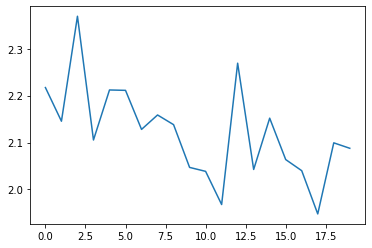

Epoch,19
Train loss,2.08779
validation loss,2.06878
Validation Acc,25.1
_runtime,2671
_timestamp,1618225323
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,▅▄█▄▅▅▄▅▄▃▃▁▆▃▄▃▃▁▄▃
validation loss,█▆▅▅▆▆▄▆▂▆▂▁▅▂▄▂▂▁▃▂
Validation Acc,▁▁▁▂▂▃▄▅▄▄▅▆▄▆▆▅▅▆█▆
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: rvrsicpd with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 0
wandb: 	batch_size: 128
wandb: 	drop_out: 0.2
wandb: 	file_org: 1
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 32


10
8
4
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.23 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.14 
Iteration : 0/71 , Loss: 2.16 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.04 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.03 
Iteration : 0/71 , Loss: 2.21 
Iteration : 0/71 , Loss: 2.04 
Iteration : 0/71 , Loss: 1.91 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 1.98 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 1.99 
Iteration : 0/71 , Loss: 1.95 
Iteration : 0/71 , Loss: 1.98 
Iteration : 0/71 , Loss: 2.00 


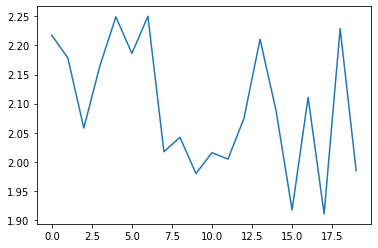

Epoch,19
Train loss,1.98463
validation loss,2.10056
Validation Acc,28.2
_runtime,2710
_timestamp,1618228041
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,▇▇▄▆█▇█▃▄▂▃▃▄▇▅▁▅▁█▃
validation loss,█▆▆▅▅▆▅▄▄▃▂▄▂▅▅▄▄▄▁▃
Validation Acc,▁▁▂▂▂▄▃▄▅▃▆▃▄▃▄▅▄▆▇█
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: x2askn7c with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 0
wandb: 	batch_size: 128
wandb: 	drop_out: 0.2
wandb: 	file_org: 2
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 16


10
8
4
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.24 
Iteration : 0/71 , Loss: 2.10 
Iteration : 0/71 , Loss: 2.20 
Iteration : 0/71 , Loss: 2.17 
Iteration : 0/71 , Loss: 2.05 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 2.10 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.00 
Iteration : 0/71 , Loss: 2.04 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 1.96 
Iteration : 0/71 , Loss: 2.04 
Iteration : 0/71 , Loss: 2.05 
Iteration : 0/71 , Loss: 2.01 
Iteration : 0/71 , Loss: 1.99 
Iteration : 0/71 , Loss: 2.14 


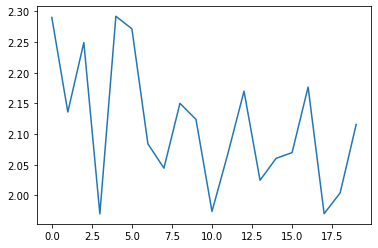

Epoch,19
Train loss,2.11565
validation loss,2.10033
Validation Acc,26.8
_runtime,2695
_timestamp,1618230744
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,█▅▇▁██▃▃▅▄▁▃▅▂▃▃▅▁▂▄
validation loss,██▇█▅▇▇▅▃▅▄▁▅▄▃▅▅▁▄▅
Validation Acc,▁▂▂▃▄▃▄▄▆▄▆▆▇▆▆▆▆▇█▆
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: zvu9t8mk with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 0
wandb: 	batch_size: 128
wandb: 	drop_out: 0.2
wandb: 	file_org: 2
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 32


10
8
4
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.26 
Iteration : 0/71 , Loss: 2.08 


In [ ]:
wandb.agent(sweep_id12,train)

In [ ]:
sweep_config={
    "name":"Assignment2Q2",
    "method":"grid",
    "metric":{
        'name':'accuracy',
        'goal' : 'maximize'
    },
    "parameters":{
      "batch_norm":{
          "values":[0]
      },
      "no_of_layers":{
          "values":[32]
      },
      "file_org":{
          "values":[2]
      },
      "Filter_size":{
          "values":[3]
      },
      "max_epochs":{
          "values":[20] 
      },
      "batch_size":{
          "values":[128]
      },
      "drop_out":{
          "values":[0.2]
      }


    }
}

In [ ]:
sweep_id4=wandb.sweep(sweep_config,entity="siddharth",project="Assignment2Q2")

Create sweep with ID: usl21o05
Sweep URL: https://wandb.ai/siddharth/Assignment2Q2/sweeps/usl21o05


wandb: Agent Starting Run: z6l71djx with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 0
wandb: 	batch_size: 128
wandb: 	drop_out: 0.2
wandb: 	file_org: 2
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 32


10
8
4
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.24 
Iteration : 0/71 , Loss: 2.20 
Iteration : 0/71 , Loss: 2.16 
Iteration : 0/71 , Loss: 2.11 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.25 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.01 
Iteration : 0/71 , Loss: 2.18 
Iteration : 0/71 , Loss: 2.10 
Iteration : 0/71 , Loss: 2.08 
Iteration : 0/71 , Loss: 2.01 
Iteration : 0/71 , Loss: 2.06 
Iteration : 0/71 , Loss: 2.03 
Iteration : 0/71 , Loss: 2.01 
Iteration : 0/71 , Loss: 2.08 
Iteration : 0/71 , Loss: 1.99 
Iteration : 0/71 , Loss: 2.05 
Iteration : 0/71 , Loss: 1.93 


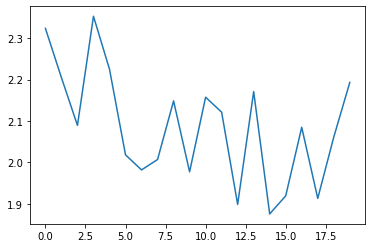

Epoch,19
Train loss,2.19296
validation loss,2.05168
Validation Acc,25.2
_runtime,3175
_timestamp,1618236305
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,█▆▄█▆▃▃▃▅▂▅▅▁▅▁▂▄▂▄▆
validation loss,█▆▇▆▆█▆▄▅▄▅▃▄▅▁▃▄▃▂▃
Validation Acc,▁▃▅▄▃▄▄▃▆▆▆▅▆█▇█▆▇▇█
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
wandb.agent(sweep_id4,train)

In [ ]:
sweep_config={
    "name":"Assignment2Q2",
    "method":"grid",
    "metric":{
        'name':'accuracy',
        'goal' : 'maximize'
    },
    "parameters":{
      "batch_norm":{
          "values":[0]
      },
      "no_of_layers":{
          "values":[16,32]
      },
      "file_org":{
          "values":[0.5,1,2]
      },
      "Filter_size":{
          "values":[3]
      },
      "max_epochs":{
          "values":[20] 
      },
      "batch_size":{
          "values":[128]
      },
      "drop_out":{
          "values":[0.5]
      }


    }
}

In [ ]:
sweep_id5=wandb.sweep(sweep_config,entity="siddharth",project="Assignment2Q2")

Create sweep with ID: 9nu8eoxw
Sweep URL: https://wandb.ai/siddharth/Assignment2Q2/sweeps/9nu8eoxw


wandb: Agent Starting Run: gtxlkvh0 with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 0
wandb: 	batch_size: 128
wandb: 	drop_out: 0.5
wandb: 	file_org: 0.5
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 16


10
8
4
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.30 


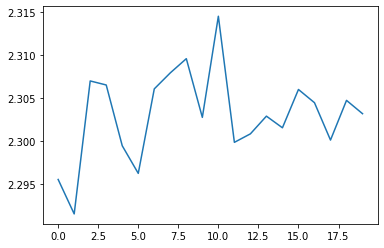

Epoch,19
Train loss,2.30315
validation loss,2.2999
Validation Acc,9.2
_runtime,3081
_timestamp,1618239743
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,▂▁▆▆▃▂▅▆▆▄█▄▄▄▄▅▅▄▅▅
validation loss,█▃█▂▃▄▅▅▃▃▄▆▁▄▂▄▄▅▄▃
Validation Acc,▅█▃▂▁▆▃▂▆▂▂▄▂▄▃▄▂▁▃▂
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 654nuwqm with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 0
wandb: 	batch_size: 128
wandb: 	drop_out: 0.5
wandb: 	file_org: 0.5
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 32


10
8
4
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.30 


Epoch,2
Train loss,2.30249
validation loss,2.30093
Validation Acc,9.1
_runtime,469
_timestamp,1618240231
_step,2


Epoch,▁▅█
Train loss,█▁▃
validation loss,▅█▁
Validation Acc,▆█▁
_runtime,▁▅█
_timestamp,▁▅█
_step,▁▅█


wandb: Agent Starting Run: d6ds8thk with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 0
wandb: 	batch_size: 128
wandb: 	drop_out: 0.5
wandb: 	file_org: 1
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 16


10
8
4
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.24 
Iteration : 0/71 , Loss: 2.26 
Iteration : 0/71 , Loss: 2.23 
Iteration : 0/71 , Loss: 2.14 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.19 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.06 
Iteration : 0/71 , Loss: 2.01 
Iteration : 0/71 , Loss: 2.08 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 2.18 
Iteration : 0/71 , Loss: 2.08 
Iteration : 0/71 , Loss: 2.08 
Iteration : 0/71 , Loss: 2.08 


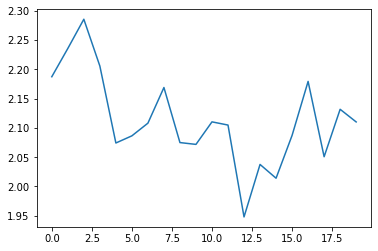

Epoch,19
Train loss,2.11017
validation loss,2.14274
Validation Acc,23.8
_runtime,3091
_timestamp,1618243400
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,▆▇█▆▄▄▄▆▄▄▄▄▁▃▂▄▆▃▅▄
validation loss,█▆▄▃▃▂▂▃▂▄▅▃▄▁▂▃▃▁▃▁
Validation Acc,▁▁▃▃▁▄▂▄▄▆▅▅▄▆▅▄▆▆▆█
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: xjduknyn with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 0
wandb: 	batch_size: 128
wandb: 	drop_out: 0.5
wandb: 	file_org: 1
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 32


10
8
4
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.26 
Iteration : 0/71 , Loss: 2.26 
Iteration : 0/71 , Loss: 2.21 
Iteration : 0/71 , Loss: 2.20 
Iteration : 0/71 , Loss: 2.16 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.20 
Iteration : 0/71 , Loss: 2.21 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 2.21 
Iteration : 0/71 , Loss: 2.08 
Iteration : 0/71 , Loss: 2.00 
Iteration : 0/71 , Loss: 2.06 
Iteration : 0/71 , Loss: 2.10 
Iteration : 0/71 , Loss: 2.08 


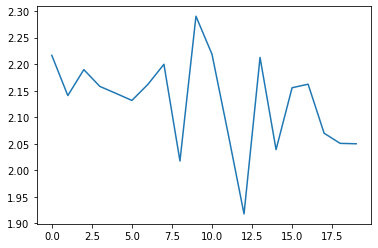

Epoch,19
Train loss,2.04985
validation loss,2.17926
Validation Acc,21.5
_runtime,3123
_timestamp,1618246535
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,▇▅▆▆▅▅▆▆▃█▇▄▁▇▃▅▆▄▃▃
validation loss,█▇▅▇█▇▅▅▅▆▇▄▅▄▅▄▁▂▁▅
Validation Acc,▁▁▃▄▄▄▃▄▄▂▅▅▅▅▆▇▇█▆▇
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: ev1z55fp with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 0
wandb: 	batch_size: 128
wandb: 	drop_out: 0.5
wandb: 	file_org: 2
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 16


10
8
4
Iteration : 0/71 , Loss: 2.30 


In [ ]:
wandb.agent(sweep_id5,train)

In [ ]:
sweep_config={
    "name":"Assignment2Q2",
    "method":"grid",
    "metric":{
        'name':'accuracy',
        'goal' : 'maximize'
    },
    "parameters":{
      "batch_norm":{
          "values":[0]
      },
      "no_of_layers":{
          "values":[16,32]
      },
      "file_org":{
          "values":[2]
      },
      "Filter_size":{
          "values":[3]
      },
      "max_epochs":{
          "values":[20] 
      },
      "batch_size":{
          "values":[128]
      },
      "drop_out":{
          "values":[0.5]
      }


    }
}

In [ ]:
sweep_id9=wandb.sweep(sweep_config,entity="siddharth",project="Assignment2Q2")

Create sweep with ID: nn2xy4bx
Sweep URL: https://wandb.ai/siddharth/Assignment2Q2/sweeps/nn2xy4bx


wandb: Agent Starting Run: nilk4axz with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 0
wandb: 	batch_size: 128
wandb: 	drop_out: 0.5
wandb: 	file_org: 2
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 16


10
8
4
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.25 
Iteration : 0/71 , Loss: 2.23 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.24 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.10 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.14 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.22 
Iteration : 0/71 , Loss: 2.10 
Iteration : 0/71 , Loss: 1.94 
Iteration : 0/71 , Loss: 2.06 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 1.99 
Iteration : 0/71 , Loss: 2.12 


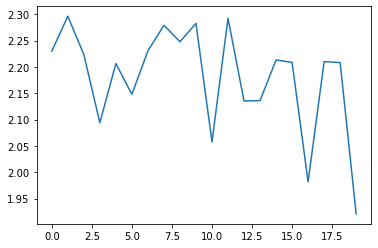

Epoch,19
Train loss,1.92102
validation loss,2.05727
Validation Acc,24.7
_runtime,2932
_timestamp,1618255327
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,▇█▇▄▆▅▇█▇█▄█▅▅▆▆▂▆▆▁
validation loss,█▇▆█▅▆█▆▇▅▅▇▃▅▁▆▇▅▁▃
Validation Acc,▂▄▄▁▃▆▄▅▄▅▅▅▆▇▆▆▆█▆▇
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: hdhcikp0 with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 0
wandb: 	batch_size: 128
wandb: 	drop_out: 0.5
wandb: 	file_org: 2
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 32


10
8
4
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.23 
Iteration : 0/71 , Loss: 2.19 
Iteration : 0/71 , Loss: 2.16 
Iteration : 0/71 , Loss: 2.20 
Iteration : 0/71 , Loss: 2.11 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.18 
Iteration : 0/71 , Loss: 2.10 
Iteration : 0/71 , Loss: 2.06 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.05 
Iteration : 0/71 , Loss: 2.14 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.14 


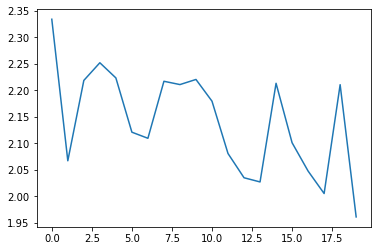

Epoch,19
Train loss,1.96127
validation loss,2.08815
Validation Acc,22.5
_runtime,3015
_timestamp,1618258351
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,█▃▆▆▆▄▄▆▆▆▅▃▂▂▆▄▃▂▆▁
validation loss,█▅▆▅▆▄▄▅▄▄▄▃▄▃▃▃▃▁▄▃
Validation Acc,▁▄▄▅▄▅▆▄▅▅▅▆▅█▆▇▆█▆▆
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
wandb.agent(sweep_id9,train)

In [ ]:
sweep_config={
    "name":"Assignment2Q2",
    "method":"grid",
    "metric":{
        'name':'accuracy',
        'goal' : 'maximize'
    },
    "parameters":{
      "batch_norm":{
          "values":[1]
      },
      "no_of_layers":{
          "values":[64,32]
      },
      "file_org":{
          "values":[1,0.5]
      },
      "Filter_size":{
          "values":[3]
      },
      "max_epochs":{
          "values":[20] 
      },
      "batch_size":{
          "values":[128]
      },
      "drop_out":{
          "values":[0.0]
      }


    }
}

In [ ]:
cc

Create sweep with ID: oga534vq
Sweep URL: https://wandb.ai/siddharth/Assignment2Q2/sweeps/oga534vq


wandb: Agent Starting Run: peu4i6xl with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 1
wandb: 	batch_size: 128
wandb: 	drop_out: 0.2
wandb: 	file_org: 1
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 64
wandb: Currently logged in as: siddharth (use `wandb login --relogin` to force relogin)


10
8
4
Iteration : 0/71 , Loss: 2.33 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.02 
Iteration : 0/71 , Loss: 2.00 
Iteration : 0/71 , Loss: 1.99 
Iteration : 0/71 , Loss: 2.00 
Iteration : 0/71 , Loss: 2.02 
Iteration : 0/71 , Loss: 1.96 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 1.94 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 2.05 
Iteration : 0/71 , Loss: 1.96 
Iteration : 0/71 , Loss: 1.87 
Iteration : 0/71 , Loss: 1.90 
Iteration : 0/71 , Loss: 1.93 
Iteration : 0/71 , Loss: 1.94 
Iteration : 0/71 , Loss: 1.79 
Iteration : 0/71 , Loss: 1.84 


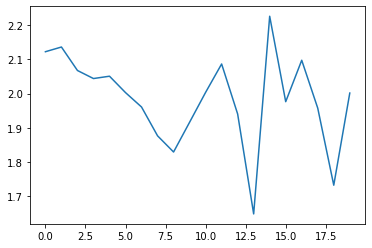

Epoch,19
Train loss,2.00154
validation loss,1.87866
Validation Acc,30.1
_runtime,2757
_timestamp,1618262233
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,▇▇▆▆▆▅▅▄▃▄▅▆▅▁█▅▆▅▂▅
validation loss,█▆▆▄▅▄▄▃▆▃▄▄▃▁▃▂▂▂▃▂
Validation Acc,▁▃▃▃▄▃▅▅▅▅▆▅▆▇▅▆█▇█▇
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tmuhnrey with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 1
wandb: 	batch_size: 128
wandb: 	drop_out: 0.2
wandb: 	file_org: 1
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 32


10
8
4
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.11 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.06 
Iteration : 0/71 , Loss: 2.18 
Iteration : 0/71 , Loss: 1.86 
Iteration : 0/71 , Loss: 2.01 
Iteration : 0/71 , Loss: 2.04 
Iteration : 0/71 , Loss: 2.08 
Iteration : 0/71 , Loss: 2.05 
Iteration : 0/71 , Loss: 1.94 
Iteration : 0/71 , Loss: 1.95 
Iteration : 0/71 , Loss: 2.04 
Iteration : 0/71 , Loss: 1.89 
Iteration : 0/71 , Loss: 1.94 
Iteration : 0/71 , Loss: 1.92 
Iteration : 0/71 , Loss: 1.94 
Iteration : 0/71 , Loss: 1.95 
Iteration : 0/71 , Loss: 1.86 
Iteration : 0/71 , Loss: 2.02 


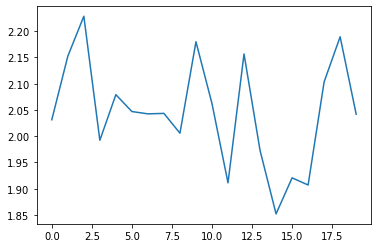

Epoch,19
Train loss,2.04207
validation loss,1.83286
Validation Acc,31.7
_runtime,2700
_timestamp,1618264951
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,▄▇█▄▅▅▅▅▄▇▅▂▇▃▁▂▂▆▇▅
validation loss,█▆▄▄▆▅▅▅▅▃▄▄▄▂▄▄▁▃▁▂
Validation Acc,▂▁▂▄▅▄▄▄▄▄▄▅▆▇▇▇▇█▇█
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: zwm3rz2o with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 1
wandb: 	batch_size: 128
wandb: 	drop_out: 0.2
wandb: 	file_org: 2
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 64


10
8
4
Iteration : 0/71 , Loss: 2.35 
Iteration : 0/71 , Loss: 2.17 
Iteration : 0/71 , Loss: 2.20 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.24 
Iteration : 0/71 , Loss: 2.26 
Iteration : 0/71 , Loss: 2.14 
Iteration : 0/71 , Loss: 2.14 
Iteration : 0/71 , Loss: 2.16 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.18 
Iteration : 0/71 , Loss: 2.14 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.19 
Iteration : 0/71 , Loss: 2.08 
Iteration : 0/71 , Loss: 2.20 
Iteration : 0/71 , Loss: 2.21 
Iteration : 0/71 , Loss: 2.11 


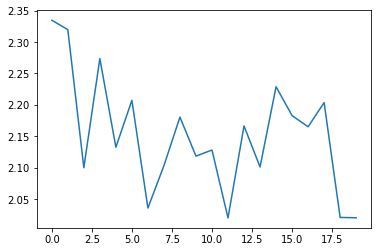

Epoch,19
Train loss,2.0203
validation loss,2.1224
Validation Acc,19.3
_runtime,2878
_timestamp,1618267837
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,██▃▇▄▅▁▃▅▃▃▁▄▃▆▅▄▅▁▁
validation loss,█▇▆▄▃▄▂▃▅▄▆▅▄▃▁▃▄▂▁▄
Validation Acc,▁▁▁▅▅▅▆█▅▇▇▇▇▅▆▇█▆█▇
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: skwfpqu7 with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 1
wandb: 	batch_size: 128
wandb: 	drop_out: 0.2
wandb: 	file_org: 2
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 32


10
8
4
Iteration : 0/71 , Loss: 2.29 
Iteration : 0/71 , Loss: 2.19 
Iteration : 0/71 , Loss: 2.29 
Iteration : 0/71 , Loss: 2.23 
Iteration : 0/71 , Loss: 2.19 
Iteration : 0/71 , Loss: 2.17 
Iteration : 0/71 , Loss: 2.16 
Iteration : 0/71 , Loss: 2.01 
Iteration : 0/71 , Loss: 2.01 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.11 
Iteration : 0/71 , Loss: 1.99 
Iteration : 0/71 , Loss: 2.11 
Iteration : 0/71 , Loss: 2.11 
Iteration : 0/71 , Loss: 1.95 
Iteration : 0/71 , Loss: 1.97 
Iteration : 0/71 , Loss: 2.03 
Iteration : 0/71 , Loss: 1.99 
Iteration : 0/71 , Loss: 2.00 
Iteration : 0/71 , Loss: 1.98 


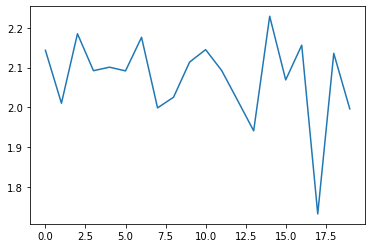

Epoch,19
Train loss,1.99651
validation loss,1.98401
Validation Acc,26.8
_runtime,2813
_timestamp,1618270658
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,▇▅▇▆▆▆▇▅▅▆▇▆▅▄█▆▇▁▇▅
validation loss,█▇▆▅▅▄▄▅▃▄▂▃▃▃▂▄▁▃▃▃
Validation Acc,▁▂▄▆▄▄▄▆▆▆▇▆▆▆▇▆█▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 6y86whf3 with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 1
wandb: 	batch_size: 128
wandb: 	drop_out: 0.2
wandb: 	file_org: 0.5
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 64


10
8
4
Iteration : 0/71 , Loss: 2.33 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.18 
Iteration : 0/71 , Loss: 2.08 
Iteration : 0/71 , Loss: 2.01 
Iteration : 0/71 , Loss: 2.08 
Iteration : 0/71 , Loss: 2.02 
Iteration : 0/71 , Loss: 2.03 
Iteration : 0/71 , Loss: 2.16 
Iteration : 0/71 , Loss: 2.02 
Iteration : 0/71 , Loss: 2.10 
Iteration : 0/71 , Loss: 2.06 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 2.00 
Iteration : 0/71 , Loss: 2.04 
Iteration : 0/71 , Loss: 2.07 


In [ ]:
wandb.agent(sweep_id10,train)

wandb: Agent Starting Run: phvyjs4z with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 1
wandb: 	batch_size: 128
wandb: 	drop_out: 0.2
wandb: 	file_org: 0.5
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 64
wandb: Currently logged in as: siddharth (use `wandb login --relogin` to force relogin)


10
8
4
Iteration : 0/71 , Loss: 2.35 
Iteration : 0/71 , Loss: 2.28 
Iteration : 0/71 , Loss: 2.20 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 2.17 
Iteration : 0/71 , Loss: 2.03 
Iteration : 0/71 , Loss: 2.05 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.02 
Iteration : 0/71 , Loss: 2.14 
Iteration : 0/71 , Loss: 1.92 
Iteration : 0/71 , Loss: 2.10 
Iteration : 0/71 , Loss: 1.99 
Iteration : 0/71 , Loss: 1.96 
Iteration : 0/71 , Loss: 1.99 
Iteration : 0/71 , Loss: 2.01 
Iteration : 0/71 , Loss: 1.97 
Iteration : 0/71 , Loss: 1.97 
Iteration : 0/71 , Loss: 2.10 


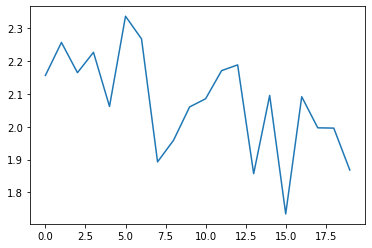

Epoch,19
Train loss,1.86807
validation loss,1.98546
Validation Acc,27.4
_runtime,2739
_timestamp,1618288175
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,▆▇▆▇▅█▇▃▄▅▅▆▆▂▅▁▅▄▄▃
validation loss,▇█▆▆▃▆▃▆▅▁▃▃▂▂▃▄▃▃▁▁
Validation Acc,▁▂▃▄▃▃▅▆▄▇▆▇▆▆▆█▇█▇█
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: fxog8gn3 with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 1
wandb: 	batch_size: 128
wandb: 	drop_out: 0.2
wandb: 	file_org: 0.5
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 32


10
8
4
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.24 
Iteration : 0/71 , Loss: 2.26 
Iteration : 0/71 , Loss: 2.25 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.14 
Iteration : 0/71 , Loss: 2.05 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.14 
Iteration : 0/71 , Loss: 2.02 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.08 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.16 
Iteration : 0/71 , Loss: 2.06 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.09 


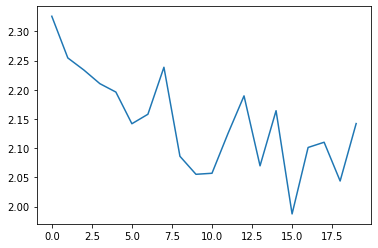

Epoch,19
Train loss,2.14214
validation loss,2.00001
Validation Acc,23.2
_runtime,2706
_timestamp,1618290893
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,█▇▆▆▅▄▅▆▃▂▂▄▅▃▅▁▃▄▂▄
validation loss,██▄▃▃▃▄▅▃▄▃▂▄▂▃▃▃▃▄▁
Validation Acc,▁▅▆▅▅▆▆█▆▇▇█▇▆▇█▆▇▇█
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
wandb.agent(sweep_id11,train)

wandb: Agent Starting Run: 7gtexnj3 with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 1
wandb: 	batch_size: 128
wandb: 	drop_out: 0
wandb: 	file_org: 1
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 64


10
8
4
Iteration : 0/71 , Loss: 2.35 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.11 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.02 
Iteration : 0/71 , Loss: 1.93 
Iteration : 0/71 , Loss: 1.95 
Iteration : 0/71 , Loss: 2.01 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.01 
Iteration : 0/71 , Loss: 1.86 
Iteration : 0/71 , Loss: 1.95 
Iteration : 0/71 , Loss: 1.78 
Iteration : 0/71 , Loss: 1.82 
Iteration : 0/71 , Loss: 1.86 
Iteration : 0/71 , Loss: 1.79 
Iteration : 0/71 , Loss: 1.76 
Iteration : 0/71 , Loss: 1.88 
Iteration : 0/71 , Loss: 1.85 
Iteration : 0/71 , Loss: 1.80 


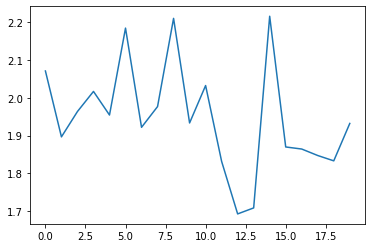

Epoch,19
Train loss,1.9322
validation loss,1.87505
Validation Acc,33.1
_runtime,2783
_timestamp,1618293871
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,▆▄▅▅▅█▄▅█▄▆▃▁▁█▃▃▃▃▄
validation loss,█▇██▇▇▅▅▅▅▆▂▂▃▃▂▂▂▂▁
Validation Acc,▁▂▃▅▄▄▄▅▅▆▆▆▆▇▆▆▆▇█▇
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: mcp9w67d with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 1
wandb: 	batch_size: 128
wandb: 	drop_out: 0
wandb: 	file_org: 1
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 32


10
8
4
Iteration : 0/71 , Loss: 2.33 
Iteration : 0/71 , Loss: 2.23 
Iteration : 0/71 , Loss: 2.05 
Iteration : 0/71 , Loss: 2.01 
Iteration : 0/71 , Loss: 1.97 
Iteration : 0/71 , Loss: 1.94 
Iteration : 0/71 , Loss: 1.96 
Iteration : 0/71 , Loss: 1.96 
Iteration : 0/71 , Loss: 1.89 
Iteration : 0/71 , Loss: 1.97 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 1.99 
Iteration : 0/71 , Loss: 1.96 
Iteration : 0/71 , Loss: 1.84 
Iteration : 0/71 , Loss: 1.91 
Iteration : 0/71 , Loss: 1.94 
Iteration : 0/71 , Loss: 1.91 
Iteration : 0/71 , Loss: 1.83 
Iteration : 0/71 , Loss: 1.86 
Iteration : 0/71 , Loss: 1.91 


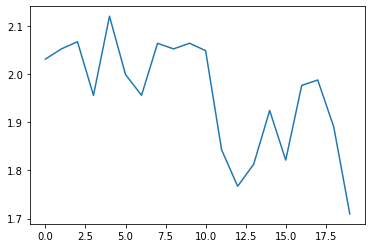

Epoch,19
Train loss,1.70958
validation loss,1.9848
Validation Acc,28.9
_runtime,2674
_timestamp,1618296555
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,▆▇▇▅█▆▅▇▇▇▇▃▂▃▅▃▆▆▄▁
validation loss,█▆▆▆▆▄▄▄▃▄▄▂▂▄▁▃▆▂▃▄
Validation Acc,▁▄▃▃▅▄▇▆▅▇▆▇█▆█▆██▇▆
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: kclcmocp with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 1
wandb: 	batch_size: 128
wandb: 	drop_out: 0
wandb: 	file_org: 0.5
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 64


10
8
4
Iteration : 0/71 , Loss: 2.36 
Iteration : 0/71 , Loss: 2.16 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.18 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.18 
Iteration : 0/71 , Loss: 2.05 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.11 
Iteration : 0/71 , Loss: 2.19 
Iteration : 0/71 , Loss: 1.95 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.10 
Iteration : 0/71 , Loss: 1.95 
Iteration : 0/71 , Loss: 1.92 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.08 
Iteration : 0/71 , Loss: 2.01 
Iteration : 0/71 , Loss: 1.94 
Iteration : 0/71 , Loss: 2.06 


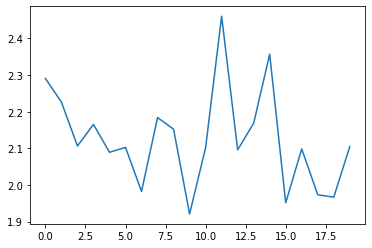

Epoch,19
Train loss,2.10485
validation loss,2.11036
Validation Acc,27.2
_runtime,2669
_timestamp,1618299233
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,▆▅▃▄▃▃▂▄▄▁▃█▃▄▇▁▃▂▂▃
validation loss,█▇▅▂▃▂▃▂▃▃▁▄▃▁▂▃▅▁▁▄
Validation Acc,▁▂▂▄▅▆▅▄▅█▆▅▆▇█▆▆███
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: a1gzu3dq with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 1
wandb: 	batch_size: 128
wandb: 	drop_out: 0
wandb: 	file_org: 0.5
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 32


10
8
4
Iteration : 0/71 , Loss: 2.32 
Iteration : 0/71 , Loss: 2.29 
Iteration : 0/71 , Loss: 2.25 
Iteration : 0/71 , Loss: 2.11 
Iteration : 0/71 , Loss: 2.16 
Iteration : 0/71 , Loss: 2.11 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 2.10 
Iteration : 0/71 , Loss: 2.16 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.11 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.02 
Iteration : 0/71 , Loss: 2.14 
Iteration : 0/71 , Loss: 2.00 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 1.96 


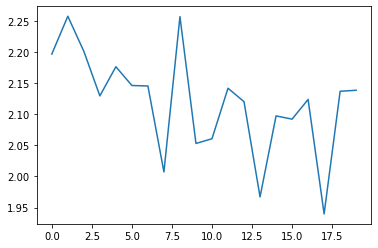

Epoch,19
Train loss,2.13849
validation loss,2.04502
Validation Acc,22.9
_runtime,2640
_timestamp,1618301881
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,▇█▇▅▆▆▆▂█▃▄▅▅▂▄▄▅▁▅▅
validation loss,██▅▅▄▄▂▁▂▃▂▂▂▂▃▃▃▂▂▁
Validation Acc,▂▁▄▆▅▅▆▆▆▇█▇█▇▆████▇
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
wandb.agent(sweep_id13,train)

In [ ]:
sweep_config={
    "name":"Assignment2Q2",
    "method":"grid",
    "metric":{
        'name':'accuracy',
        'goal' : 'maximize'
    },
    "parameters":{
      "batch_norm":{
          "values":[1]
      },
      "no_of_layers":{
          "values":[128]
      },
      "file_org":{
          "values":[1,0.5]
      },
      "Filter_size":{
          "values":[3]
      },
      "max_epochs":{
          "values":[20] 
      },
      "batch_size":{
          "values":[128]
      },
      "drop_out":{
          "values":[0.0,0.2]
      }


    }
}

In [ ]:
sweep_id14=wandb.sweep(sweep_config,entity="siddharth",project="Assignment2Q2")

Create sweep with ID: ucncutx7
Sweep URL: https://wandb.ai/siddharth/Assignment2Q2/sweeps/ucncutx7


wandb: Agent Starting Run: 3k63yfd6 with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 1
wandb: 	batch_size: 128
wandb: 	drop_out: 0
wandb: 	file_org: 1
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 128
wandb: Currently logged in as: siddharth (use `wandb login --relogin` to force relogin)


10
8
4
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.01 
Iteration : 0/71 , Loss: 1.98 
Iteration : 0/71 , Loss: 2.04 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 2.06 
Iteration : 0/71 , Loss: 2.03 
Iteration : 0/71 , Loss: 2.08 
Iteration : 0/71 , Loss: 1.77 
Iteration : 0/71 , Loss: 1.96 
Iteration : 0/71 , Loss: 1.90 
Iteration : 0/71 , Loss: 1.87 
Iteration : 0/71 , Loss: 1.87 
Iteration : 0/71 , Loss: 1.79 
Iteration : 0/71 , Loss: 1.95 
Iteration : 0/71 , Loss: 1.75 
Iteration : 0/71 , Loss: 1.88 


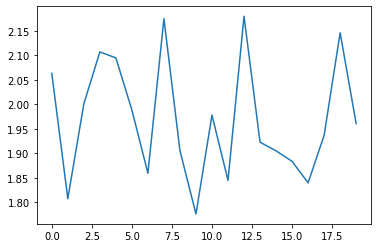

Epoch,19
Train loss,1.96055
validation loss,1.888
Validation Acc,33.4
_runtime,2831
_timestamp,1618307866
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,▆▂▅▇▇▅▂█▃▁▄▂█▄▃▃▂▄▇▄
validation loss,▇▇▇█▆▆▄▄▅▇▄█▄▃▅▂▁▄▂▃
Validation Acc,▁▁▂▂▃▅▃▄▆▆▆▆▆▇▆▆▇▆▇█
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: klx8q4yo with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 1
wandb: 	batch_size: 128
wandb: 	drop_out: 0
wandb: 	file_org: 0.5
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 128


10
8
4
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.20 
Iteration : 0/71 , Loss: 2.06 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.10 
Iteration : 0/71 , Loss: 1.99 
Iteration : 0/71 , Loss: 1.94 
Iteration : 0/71 , Loss: 1.99 
Iteration : 0/71 , Loss: 1.96 
Iteration : 0/71 , Loss: 1.84 
Iteration : 0/71 , Loss: 1.94 
Iteration : 0/71 , Loss: 1.91 
Iteration : 0/71 , Loss: 1.91 
Iteration : 0/71 , Loss: 1.91 
Iteration : 0/71 , Loss: 2.04 
Iteration : 0/71 , Loss: 1.82 
Iteration : 0/71 , Loss: 1.96 
Iteration : 0/71 , Loss: 1.89 
Iteration : 0/71 , Loss: 1.90 
Iteration : 0/71 , Loss: 1.74 


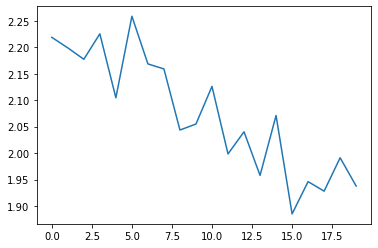

Epoch,19
Train loss,1.93767
validation loss,1.93612
Validation Acc,30.4
_runtime,2744
_timestamp,1618310619
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,▇▇▆▇▅█▆▆▄▄▆▃▄▂▄▁▂▂▃▂
validation loss,▆▇██▇▅▃▂▄▅▃▁▂▂▃▇▇▂▄▃
Validation Acc,▁▅▃▃▅▆▅▅▅▆▇▆▆▇▆▇▇█▇█
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: d6ywo13o with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 1
wandb: 	batch_size: 128
wandb: 	drop_out: 0.2
wandb: 	file_org: 1
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 128


10
8
4
Iteration : 0/71 , Loss: 2.33 
Iteration : 0/71 , Loss: 2.11 
Iteration : 0/71 , Loss: 2.11 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.03 
Iteration : 0/71 , Loss: 1.96 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 1.99 
Iteration : 0/71 , Loss: 2.02 
Iteration : 0/71 , Loss: 1.95 
Iteration : 0/71 , Loss: 2.16 
Iteration : 0/71 , Loss: 2.06 
Iteration : 0/71 , Loss: 1.92 
Iteration : 0/71 , Loss: 2.05 
Iteration : 0/71 , Loss: 1.93 
Iteration : 0/71 , Loss: 1.86 
Iteration : 0/71 , Loss: 1.85 


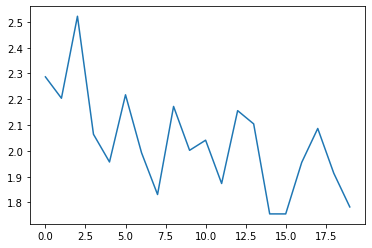

Epoch,19
Train loss,1.78263
validation loss,1.91734
Validation Acc,28.2
_runtime,2789
_timestamp,1618313417
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,▆▅█▄▃▅▃▂▅▃▄▂▅▄▁▁▃▄▂▁
validation loss,██▇▆▅▂▄▃▅▅▃▄▃▁▂▃▃▂▁▂
Validation Acc,▁▂▂▄▃▄▅▆▆▆▇▆▇▆▇▇█▇█▆
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: s9zdue12 with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 1
wandb: 	batch_size: 128
wandb: 	drop_out: 0.2
wandb: 	file_org: 0.5
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 128


10
8
4
Iteration : 0/71 , Loss: 2.29 
Iteration : 0/71 , Loss: 2.16 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.05 
Iteration : 0/71 , Loss: 2.11 
Iteration : 0/71 , Loss: 2.03 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.06 
Iteration : 0/71 , Loss: 1.97 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 1.98 
Iteration : 0/71 , Loss: 1.99 
Iteration : 0/71 , Loss: 1.94 
Iteration : 0/71 , Loss: 2.03 
Iteration : 0/71 , Loss: 2.06 
Iteration : 0/71 , Loss: 1.84 
Iteration : 0/71 , Loss: 2.01 
Iteration : 0/71 , Loss: 2.02 
Iteration : 0/71 , Loss: 1.87 
Iteration : 0/71 , Loss: 1.90 


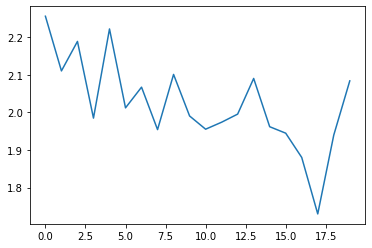

Epoch,19
Train loss,2.08427
validation loss,1.92005
Validation Acc,27.6
_runtime,2719
_timestamp,1618316144
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,█▆▇▄█▅▅▄▆▄▄▄▅▆▄▄▃▁▄▆
validation loss,█▆▅█▇▇▅▄▅▇▄▆▃▄▄▂▁▄▄▄
Validation Acc,▁▂▄▄▄▅▅▅▅▅▆▆▆▇▆▆▆█▇▆
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
wandb.agent(sweep_id14,train)

In [ ]:
sweep_config={
    "name":"Assignment2Q2",
    "method":"grid",
    "metric":{
        'name':'accuracy',
        'goal' : 'maximize'
    },
    "parameters":{
      "batch_norm":{
          "values":[0]
      },
      "no_of_layers":{
          "values":[128]
      },
      "file_org":{
          "values":[1,0.5]
      },
      "Filter_size":{
          "values":[3]
      },
      "max_epochs":{
          "values":[20] 
      },
      "batch_size":{
          "values":[128]
      },
      "drop_out":{
          "values":[0.0,0.5]
      }


    }
}

Create sweep with ID: cops4c3z
Sweep URL: https://wandb.ai/siddharth/Assignment2Q2/sweeps/cops4c3z


wandb: Agent Starting Run: 03tl05qa with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 0
wandb: 	batch_size: 128
wandb: 	drop_out: 0
wandb: 	file_org: 1
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 128
wandb: Currently logged in as: siddharth (use `wandb login --relogin` to force relogin)


10
8
4
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.27 
Iteration : 0/71 , Loss: 2.26 
Iteration : 0/71 , Loss: 2.05 
Iteration : 0/71 , Loss: 2.18 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.16 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.05 
Iteration : 0/71 , Loss: 2.11 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.23 
Iteration : 0/71 , Loss: 2.08 
Iteration : 0/71 , Loss: 2.02 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.10 
Iteration : 0/71 , Loss: 2.00 
Iteration : 0/71 , Loss: 1.96 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 1.95 


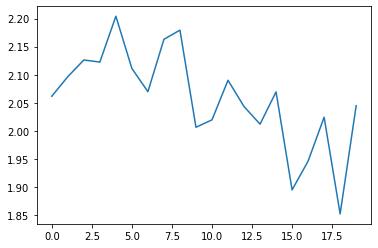

Epoch,19
Train loss,2.04474
validation loss,1.96374
Validation Acc,28.5
_runtime,2748
_timestamp,1618339471
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,▅▆▆▆█▆▅▇█▄▄▆▅▄▅▂▃▄▁▅
validation loss,█▇▆▆▅▆▅▄▄▅▃▅▃▃▂▃▂▂▃▁
Validation Acc,▁▂▄▃▄▃▅▅▆▅▅▅▇▇█▆▆███
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 0ddoihmc with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 0
wandb: 	batch_size: 128
wandb: 	drop_out: 0
wandb: 	file_org: 0.5
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 128


10
8
4
Iteration : 0/71 , Loss: 2.30 
Iteration : 0/71 , Loss: 2.19 
Iteration : 0/71 , Loss: 2.14 
Iteration : 0/71 , Loss: 2.11 
Iteration : 0/71 , Loss: 2.18 
Iteration : 0/71 , Loss: 2.14 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 2.17 
Iteration : 0/71 , Loss: 2.01 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.04 
Iteration : 0/71 , Loss: 2.04 
Iteration : 0/71 , Loss: 1.96 
Iteration : 0/71 , Loss: 1.94 
Iteration : 0/71 , Loss: 1.99 
Iteration : 0/71 , Loss: 2.06 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.01 
Iteration : 0/71 , Loss: 2.09 


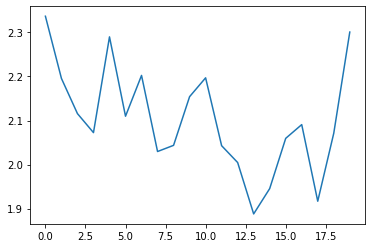

Epoch,19
Train loss,2.30085
validation loss,1.93915
Validation Acc,27.1
_runtime,2710
_timestamp,1618342189
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,█▆▅▄▇▄▆▃▃▅▆▃▃▁▂▄▄▁▄▇
validation loss,███▇▅▆▅▄▅▅▃▄▅▃▄▅▄▃▃▁
Validation Acc,▁▃▄▃▆▅▅▅▅▅▆▅▆▇▇▅▆▇█▇
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: tjtpcbvv with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 0
wandb: 	batch_size: 128
wandb: 	drop_out: 0.5
wandb: 	file_org: 1
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 128


10
8
4
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.32 
Iteration : 0/71 , Loss: 2.21 
Iteration : 0/71 , Loss: 2.25 
Iteration : 0/71 , Loss: 2.22 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.19 
Iteration : 0/71 , Loss: 2.23 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 2.14 
Iteration : 0/71 , Loss: 2.07 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.02 
Iteration : 0/71 , Loss: 2.14 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 2.08 
Iteration : 0/71 , Loss: 2.08 


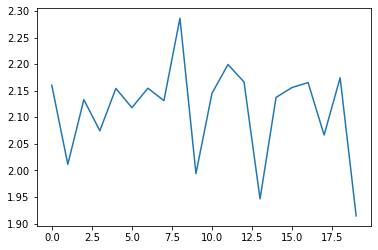

Epoch,19
Train loss,1.91445
validation loss,2.0586
Validation Acc,25.3
_runtime,2858
_timestamp,1618345056
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,▆▃▅▄▆▅▆▅█▃▅▆▆▂▅▆▆▄▆▁
validation loss,█▆▆▆▄▃▃▄▅▅▆▄▃▂▃▃▁▁▂▂
Validation Acc,▁▃▄▄▅▅▆▅▅█▆▆▆▆▇▆▇▆▇█
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: g9xky1uu with config:
wandb: 	Filter_size: 3
wandb: 	batch_norm: 0
wandb: 	batch_size: 128
wandb: 	drop_out: 0.5
wandb: 	file_org: 0.5
wandb: 	max_epochs: 20
wandb: 	no_of_layers: 128


10
8
4
Iteration : 0/71 , Loss: 2.31 
Iteration : 0/71 , Loss: 2.27 
Iteration : 0/71 , Loss: 2.17 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.24 
Iteration : 0/71 , Loss: 2.12 
Iteration : 0/71 , Loss: 2.14 
Iteration : 0/71 , Loss: 2.16 
Iteration : 0/71 , Loss: 2.15 
Iteration : 0/71 , Loss: 2.17 
Iteration : 0/71 , Loss: 2.04 
Iteration : 0/71 , Loss: 2.13 
Iteration : 0/71 , Loss: 2.05 
Iteration : 0/71 , Loss: 2.02 
Iteration : 0/71 , Loss: 2.18 
Iteration : 0/71 , Loss: 2.00 
Iteration : 0/71 , Loss: 2.04 
Iteration : 0/71 , Loss: 2.09 
Iteration : 0/71 , Loss: 1.99 
Iteration : 0/71 , Loss: 2.05 


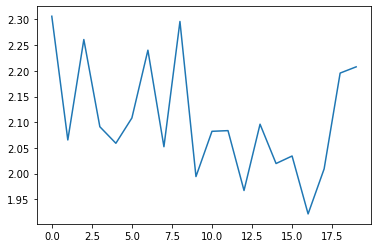

Epoch,19
Train loss,2.20779
validation loss,2.03626
Validation Acc,25.9
_runtime,2727
_timestamp,1618347793
_step,19


Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train loss,█▄▇▄▄▄▇▃█▂▄▄▂▄▃▃▁▃▆▆
validation loss,█▅▅▄▄▄▄▂▃▄▂▁▃▃▂▁▁▂▂▁
Validation Acc,▁▂▂▃▃▆▅▅▄▅▆▇▅▇▇▆▆▆█▇
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
sweep_id16=wandb.sweep(sweep_config,entity="siddharth",project="Assignment2Q2")
wandb.agent(sweep_id16,train)